# CMPE 258 HW 6 - Mnist Image classification in pytorch
## Abhishek Bais

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()

True

# 1.0. Data injestion

In [2]:
mean_gray= 0.1307
stddev_gray= 0.3081
#normalize the image with std and mean
#e.g: input[channel]=(input[channel]-mean[channel])/std(channel)
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset=datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 2.0. Data Exploration

label: 0


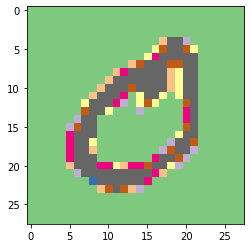

In [4]:
import matplotlib.pyplot as plt
label=train_dataset[21][1]
print('label:', label)
random_image = train_dataset[21][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='Accent')

# 3.0. Setup dataloaders to train/ test

In [5]:
batch_size=100
epochs=10
train_load=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_load=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


# 4.0. Create a CNN model

### Extra points
1. Added different model 
2. Added pooling layer
3. Dropout 0.3
4. padding same


In [21]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # Add layer 1  - CNN, BatchNorm, Relu, MaxPool
    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
      
    # Add layer 2 - CNN, BatchNorm, Relu, MaxPool
    self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
    )
        
    # Add layer 3 - Linear, Dropout, Linear, Dropout
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.3)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.drop = nn.Dropout2d(0.3)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.drop(out)
    return out

# 5.0. Define hyper-params, build the model

### Extra points
1. New optimizer     - sgd
2. New learning rate - 0.001
3. Added momemtum    - 0.9

In [26]:

learning_rate = 0.001
loss_fn=nn.CrossEntropyLoss()
#loss_fn = nn.L1Loss()
momemtum = 0.9

model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momemtum)

# 6.0. Check expected predictions

In [27]:
iteration=0
correct_nodata=0
correct_data=0
for i,(inputs,labels) in enumerate (train_load):
  if iteration==1:
    break
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()

  print("For 1 iteration, this is what happens:")
  print("Input Shape:",inputs.shape)
  print("Labels Shape:", labels.shape)
  output = model(inputs)
  
  print("Output Shape:",output.shape)
  _,predicted_nodata=torch.max(output,1)
  
  print("Predicted Shape:",predicted_nodata.shape)
  print("Predicted Tensor:",predicted_nodata)
  correct_nodata +=(predicted_nodata==labels).sum()
  print("Correct Predictions:",correct_nodata)
  _,predicted_data = torch.max(output.data,1)
  correct_data +=(predicted_data==labels.data).sum()
  
  print("Correct Predictions:",correct_data)
  
  iteration+=1

For 1 iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 120])
Predicted Shape: torch.Size([100])
Predicted Tensor: tensor([ 11,  11,  11, 115,  43,  71,  26,  71,  43,  94,   1,  11,   2,  39,
         26,  74,  85,  11,  81,  94,  26,  85,  81,  11,  11,  39, 115,  82,
         11, 109,   4,  85,  71,  27,  11,  81,  10,  81,  43,  54,  81,  61,
         10,  43,  43,  94,  94,  87,  39, 108,  43,  35, 101,  33,  71,  51,
         71,  11,  81,  19,  43,  10,  54,  11,  61,  11,  61,  81,  33,  11,
         26,  77,  43,  11,   2,  43,  26,  43,  54,  81, 116,  85,  11,  11,
         11,  43,  43,  11,  43,  94,  71,  45,  43,  54,  43, 108,  71,  81,
         33,  43], device='cuda:0')
Correct Predictions: tensor(0, device='cuda:0')
Correct Predictions: tensor(0, device='cuda:0')


# 7.0. Train/ Test

In [28]:
num_epochs=20

train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]

# Training
for epoch in range(num_epochs):
  # Reset variables at 0 epoch
  correct=0
  iteration=0
  iter_loss=0.0
  
  model.train() # Training Mode
  
  for i,(inputs,labels) in enumerate(train_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    # if CUDA is avaible, shift to GPU (CUDA)
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
      
    optimizer.zero_grad() # clear gradient
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    iter_loss += loss.item() # Accumulate loss
    loss.backward() # backpropagation
    optimizer.step() # update weights
    
    # Save the correct predictions for training data
    _,predicted=torch.max(outputs,1)
    correct +=(predicted==labels).sum()
    iteration +=1
    
  train_loss.append(iter_loss/iteration)
  train_accuracy.append((100*correct/len(train_dataset)))
  
  # Testing
  correct=0
  iteration=0
  loss=0.0
  
  model.eval()  # Testing Mode
  
  for i, (inputs, labels) in enumerate(test_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
    
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss += loss.item()
    
    _,predicted=torch.max(outputs,1)
    correct+=(predicted==labels).sum()
    
    iteration+=1
    
  test_loss.append(loss/iteration)
  test_accuracy.append((100*correct/len(test_dataset)))
  
  print('Epoch {}/{}, Training Loss:{:.3f}, Training Accuracy:{:.3f}, Testing Loss {:.3f}, Testing Accuracy:{:.3f}'
       .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))
  
    

Epoch 1/20, Training Loss:1.517, Training Accuracy:66.093, Testing Loss 0.003, Testing Accuracy:96.750
Epoch 2/20, Training Loss:1.236, Training Accuracy:72.247, Testing Loss 0.002, Testing Accuracy:97.820
Epoch 3/20, Training Loss:1.205, Training Accuracy:73.777, Testing Loss 0.001, Testing Accuracy:98.080
Epoch 4/20, Training Loss:1.182, Training Accuracy:74.765, Testing Loss 0.001, Testing Accuracy:98.260
Epoch 5/20, Training Loss:1.170, Training Accuracy:75.523, Testing Loss 0.001, Testing Accuracy:98.380
Epoch 6/20, Training Loss:1.161, Training Accuracy:76.110, Testing Loss 0.001, Testing Accuracy:98.570
Epoch 7/20, Training Loss:1.155, Training Accuracy:76.212, Testing Loss 0.000, Testing Accuracy:98.530
Epoch 8/20, Training Loss:1.152, Training Accuracy:76.648, Testing Loss 0.001, Testing Accuracy:98.670
Epoch 9/20, Training Loss:1.135, Training Accuracy:76.968, Testing Loss 0.000, Testing Accuracy:98.620
Epoch 10/20, Training Loss:1.147, Training Accuracy:76.768, Testing Loss 

# 8.0. Evaluate results

## 8.1. View loss

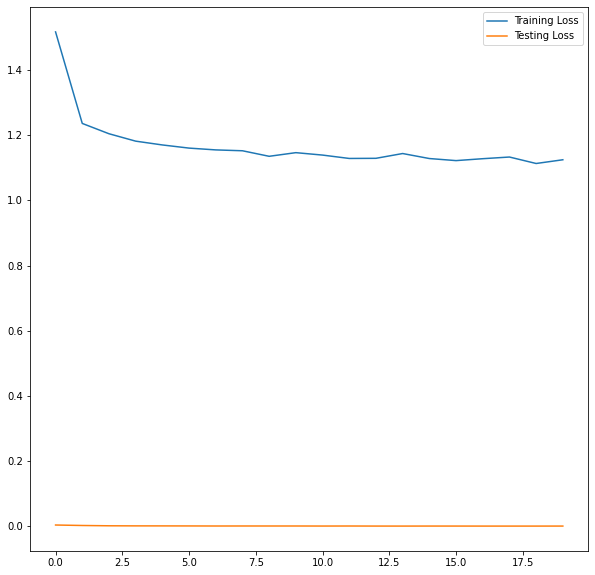

In [29]:
# Loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

## 8.2. View accuracy

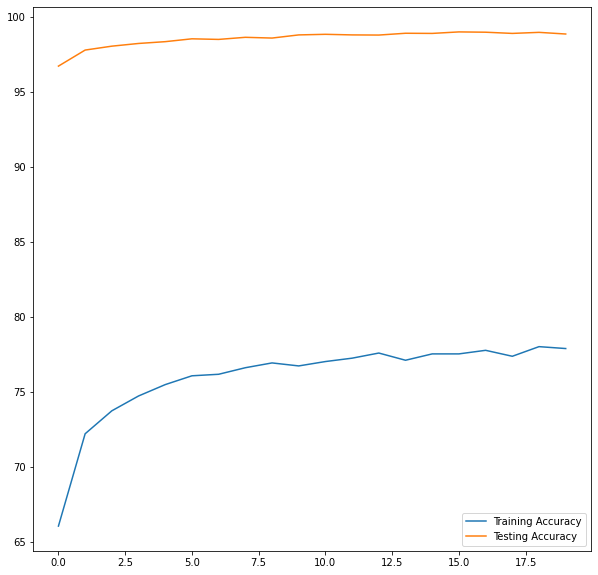

In [30]:
# Accuracy
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

## 8.3. View predictions

In [31]:
img= test_dataset[40][0].resize_((1,1,28,28))
img= Variable(img)
label= test_dataset[40][1]

model.eval()

if torch.cuda.is_available():
  model=model.cuda()
  img=img.cuda()
  
output=model(img)
print(output)
print(output.data)
_,predicted=torch.max(output,1)
print("Prediction is:",predicted.item())
print("Actual is:", label)

tensor([[-3.8013,  6.9802, -3.9081, -2.8555, -2.1363, -2.4171, -5.0007, -2.3621,
         -1.0119, -2.5009, -4.2343, -3.9993, -4.1072, -4.2822, -4.2753, -4.3271,
         -4.6636, -4.3743, -4.2923, -4.0098, -4.4998, -4.0953, -4.6784, -4.3624,
         -4.4967, -4.6794, -3.9620, -3.9347, -4.4787, -4.2856, -4.2921, -4.4348,
         -4.2862, -4.2205, -4.1015, -4.3075, -4.0206, -3.9491, -4.3784, -4.2129,
         -4.2125, -3.9659, -4.3058, -3.8153, -4.0709, -4.2242, -4.3203, -4.1887,
         -4.3357, -4.7316, -4.2101, -4.1176, -4.3466, -4.2473, -3.8771, -4.4018,
         -4.5492, -4.2417, -4.5082, -4.7350, -4.1693, -4.2280, -4.4845, -4.1906,
         -3.9814, -4.3226, -4.1520, -4.6406, -4.3807, -4.3670, -4.8528, -4.6897,
         -4.5585, -3.9617, -4.2433, -4.1224, -4.1329, -4.1532, -4.5079, -4.3270,
         -4.1489, -4.7187, -3.7143, -4.2223, -4.2969, -4.3287, -4.2908, -4.1990,
         -4.3291, -4.2907, -4.7425, -4.3121, -4.2988, -4.3164, -4.0660, -4.3476,
         -3.8177, -4.3758, -